In [ ]:
!pip install -q torch_snippets
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip


     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 214 kB 42.5 MB/s 
     |████████████████████████████████| 10.1 MB 26.6 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 


In [ ]:
from torch_snippets import *
import time
import torch
import torch.nn as nn
import numpy
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*') 
        self.transform = transform
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*', silent=True))
        else:
            while True:
                itemB = choose(self.items)
                if person != fname(parent(itemB)):
                    break
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
        return imgA, imgB, np.array([1-same_person])
    def __len__(self):
        return len(self.items)

In [ ]:
from torchvision import transforms

trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)

2021-12-04 05:29:42.953 | INFO     | torch_snippets.paths:inner:24 - 370 files found at ./data/faces/training//*/*
2021-12-04 05:29:42.959 | INFO     | torch_snippets.paths:inner:24 - 30 files found at ./data/faces/testing//*/*


In [ ]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

In [ ]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [ ]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
n_epochs = 200
Accuracy = []
Loss = []
for epoch in range(n_epochs):
    print(epoch)
    batch_acc, batch_loss = [], []
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        batch_loss.append(loss)
        batch_acc.append(acc)
    Accuracy.append(np.mean(batch_acc))
    Loss.append(np.mean(batch_loss))
    if (epoch == 10):
        optimizer = optim.Adam(model.parameters(), lr= 0.0005)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


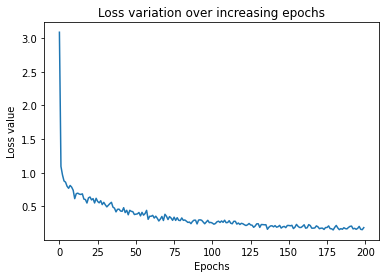

In [ ]:
plt.plot(Loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

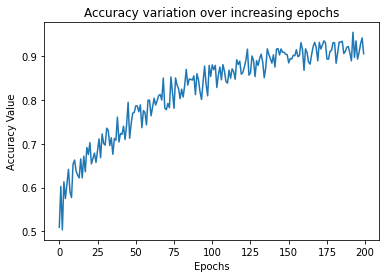

In [ ]:
plt.plot(Accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.show()

## Prediction 1

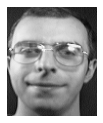

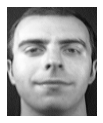

In [ ]:
img_1_path = '/content/data/faces/training/s19/2.pgm'
img_2_path = '/content/data/faces/training/s19/4.pgm'

img_1 = read(img_1_path)
img_2 = read(img_2_path)

show(img_1)
show(img_2)

img_1 = val_tfms(img_1)
img_1 = img_1.view(-1, 1, 100, 100)
img_2 = val_tfms(img_2)
img_2 = img_2.view(-1, 1, 100, 100)

In [ ]:
model.eval()
start = time.time()
output_1, output_2 = model(img_1.cuda(), img_2.cuda())
euclidean_distance = F.pairwise_distance(output_1, output_2)
end = time.time()
print(euclidean_distance.item())
print("Time", end-start)

0.2645741403102875
Time 0.00954890251159668


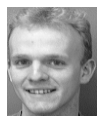

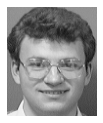

In [ ]:
img_1_path = '/content/data/faces/testing/s5/1.pgm'
img_2_path = '/content/data/faces/testing/s6/2.pgm'

img_1 = read(img_1_path)
img_2 = read(img_2_path)

show(img_1)
show(img_2)

img_1 = val_tfms(img_1)
img_1 = img_1.view(-1, 1, 100, 100)
img_2 = val_tfms(img_2)
img_2 = img_2.view(-1, 1, 100, 100)

In [ ]:
model.eval()

start = time.time()
output_1, output_2 = model(img_1.cuda(), img_2.cuda())
euclidean_distance = F.pairwise_distance(output_1, output_2)
end = time.time()
print(euclidean_distance.item())
print("Time", end-start)

1.075964093208313
Time 0.009416341781616211
